### Import libaries

In [0]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss

### Import data

In [0]:
# Read from url - Take time to run
url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
df = pd.read_csv(url, compression='bz2')

In [0]:
# Reduce rows
df = df.sample(frac=0.25)

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
4112614,2008,7,19,6,1953.0,1935,2210.0,2220,AA,787,N493AA,197.0,225.0,175.0,-10.0,18.0,LGA,DFW,1389,7.0,15.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
1094727,2008,2,20,3,1903.0,1905,2008.0,2020,AA,1982,N411AA,65.0,75.0,46.0,-12.0,-2.0,STL,ORD,258,8.0,11.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
4756308,2008,8,3,7,1326.0,1305,1546.0,1530,AA,1905,N465AA,140.0,145.0,110.0,16.0,21.0,MSP,DFW,852,9.0,21.0,0,NaN,0,0.0,0.0,0.0,0.0,16.0
2427833,2008,5,14,3,1102.0,1100,1400.0,1400,WN,1400,N368SW,118.0,120.0,106.0,0.0,2.0,STL,BWI,737,3.0,9.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
6959741,2008,12,11,4,1932.0,1940,2237.0,2220,B6,597,N558JB,185.0,160.0,164.0,17.0,-8.0,HPN,MCO,972,6.0,15.0,0,NaN,0,0.0,0.0,17.0,0.0,0.0


Variable descriptions: http://stat-computing.org/dataexpo/2009/the-data.html

Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

### Data pre-processing

In [5]:
df.count()

Year                 1752432
Month                1752432
DayofMonth           1752432
DayOfWeek            1752432
DepTime              1718219
CRSDepTime           1752432
ArrTime              1714391
CRSArrTime           1752432
UniqueCarrier        1752432
FlightNum            1752432
TailNum              1731586
ActualElapsedTime    1713642
CRSElapsedTime       1752220
AirTime              1713642
ArrDelay             1713642
DepDelay             1718219
Origin               1752432
Dest                 1752432
Distance             1752432
TaxiIn               1714391
TaxiOut              1718020
Cancelled            1752432
CancellationCode       34493
Diverted             1752432
CarrierDelay          381346
WeatherDelay          381346
NASDelay              381346
SecurityDelay         381346
LateAircraftDelay     381346
dtype: int64

In [6]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             1713642
DayofMonth        1713642
DayOfWeek         1713642
CRSArrTime        1713642
UniqueCarrier     1713642
CRSElapsedTime    1713642
AirTime           1713642
ArrDelay          1713642
DepDelay          1713642
Dest              1713642
Distance          1713642
TaxiIn            1713642
TaxiOut           1713642
dtype: int64

In [0]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [0]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [9]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
DepDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int64
Delay               int64
dtype: object

In [10]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
4112614,7,19,6,AA,225.0,175.0,-10.0,18.0,DFW,1389,7.0,15.0,4,0
1094727,2,20,3,AA,75.0,46.0,-12.0,-2.0,ORD,258,8.0,11.0,3,0
4756308,8,3,7,AA,145.0,110.0,16.0,21.0,DFW,852,9.0,21.0,2,0
2427833,5,14,3,WN,120.0,106.0,0.0,2.0,BWI,737,3.0,9.0,2,0
6959741,12,11,4,B6,160.0,164.0,17.0,-8.0,MCO,972,6.0,15.0,4,0


### Data analysis

In [11]:
#Check basic stats
df.describe()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
count,1.713642e+06,1.713642e+06,1.713642e+06,1.713642e+06,1.713642e+06,1.713642e+06,1.713642e+06,1.713642e+06,1.713642e+06,1.713642e+06,1.713642e+06,1.713642e+06
mean,6.390919e+00,1.574168e+01,3.923223e+00,1.291055e+02,1.040461e+02,8.179907e+00,9.942940e+00,7.289030e+02,6.859928e+00,1.643642e+01,2.241685e+00,1.315981e-01
std,3.399543e+00,8.798764e+00,1.988075e+00,6.957333e+01,6.748859e+01,3.847005e+01,3.518022e+01,5.637178e+02,4.927140e+00,1.132766e+01,1.018944e+00,3.380534e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.410000e+02,0.000000e+00,-1.290000e+02,-7.000000e+01,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,8.000000e+00,2.000000e+00,8.000000e+01,5.600000e+01,-1.000000e+01,-4.000000e+00,3.280000e+02,4.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00
50%,6.000000e+00,1.600000e+01,4.000000e+00,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,2.000000e+00,0.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,3.000000e+00,0.000000e+00
max,1.200000e+01,3.100000e+01,7.000000e+00,6.600000e+02,6.510000e+02,2.453000e+03,2.467000e+03,4.962000e+03,2.330000e+02,4.220000e+02,4.000000e+00,1.000000e+00


In [12]:
#Check correlation
df.corr()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Month,1.000000,-0.000883,-0.005330,-0.006755,-0.012792,-0.042448,-0.031146,-0.005911,0.008772,-0.016524,-0.004870,-0.036568
DayofMonth,-0.000883,1.000000,0.004186,0.002724,0.002325,0.002291,0.003594,0.002691,-0.002796,0.000714,-0.002475,0.000312
DayOfWeek,-0.005330,0.004186,1.000000,0.015462,0.014169,0.010790,0.015764,0.017045,0.011350,-0.006700,0.003773,0.010437
CRSElapsedTime,-0.006755,0.002724,0.015462,1.000000,0.988256,0.013103,0.035447,0.983164,0.105472,0.142545,0.090615,0.032686
AirTime,-0.012792,0.002325,0.014169,0.988256,1.000000,0.034859,0.027409,0.982946,0.086313,0.107625,0.077508,0.042597
ArrDelay,-0.042448,0.002291,0.010790,0.013103,0.034859,1.000000,0.931327,0.007208,0.123136,0.322937,0.116117,0.740940
DepDelay,-0.031146,0.003594,0.015764,0.035447,0.027409,0.931327,1.000000,0.026282,0.024586,0.100921,0.142057,0.687708
Distance,-0.005911,0.002691,0.017045,0.983164,0.982946,0.007208,0.026282,1.000000,0.078400,0.090996,0.090209,0.020535
TaxiIn,0.008772,-0.002796,0.011350,0.105472,0.086313,0.123136,0.024586,0.078400,1.000000,0.040422,-0.020203,0.089007
TaxiOut,-0.016524,0.000714,-0.006700,0.142545,0.107625,0.322937,0.100921,0.090996,0.040422,1.000000,0.056716,0.288762


In [13]:
# Groupby carrier
df.groupby(['UniqueCarrier']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
UniqueCarrier,,,,,,,,,,,,
9E,6.505798,15.736468,3.928406,100.390155,71.150146,4.147843,6.808440,451.141500,8.523215,18.056196,2.190029,0.107439
AA,6.445289,15.833535,3.953005,167.825960,142.094783,12.604275,13.215073,1058.677869,8.250565,16.869813,2.322302,0.173070
AQ,1.484974,15.494301,3.938342,73.705699,60.372021,-2.713472,-1.465803,409.038342,3.959585,8.130052,2.134197,0.029016
AS,6.416885,15.580357,3.947798,155.075424,131.851450,4.824336,6.686356,960.527426,5.791652,15.570274,2.327188,0.108621
B6,6.415175,15.862531,3.985575,179.985200,150.378726,11.338655,12.843547,1100.638114,6.268693,21.832889,2.349313,0.169421
CO,6.323492,15.738666,3.896476,186.430181,155.940680,11.071817,13.139187,1154.844455,7.976070,20.446062,2.303123,0.152858
DL,6.504577,15.727797,3.921274,156.055033,126.679225,7.944752,8.071959,923.545969,8.689780,20.558820,2.246500,0.119463
EV,6.491507,15.693151,3.929011,95.625951,69.837335,10.397756,12.111100,443.625544,7.365629,16.709642,2.100357,0.151095
F9,6.439878,15.724163,3.914854,143.269333,121.562360,6.170968,5.881319,879.191705,7.386029,14.610593,2.325801,0.092790


In [14]:
# Groupby destination airport
df.groupby(['Dest']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Dest,,,,,,,,,,,,
ABE,6.462329,15.571918,3.853596,100.093322,73.048801,8.618151,11.271404,529.620719,4.495719,19.895548,2.779110,0.137842
ABI,6.471729,15.189015,3.907916,53.079160,33.208401,8.641357,9.736672,158.000000,3.599354,15.176090,2.678514,0.135703
ABQ,6.440496,15.747097,3.931514,114.388387,92.443672,5.987792,9.038412,654.608337,5.360695,13.533400,2.293002,0.105509
ABY,6.162698,16.194444,3.964286,54.027778,27.670635,12.722222,12.154762,146.000000,3.567460,23.357143,2.559524,0.130952
ACK,7.135922,15.368932,4.300971,86.912621,45.650485,17.242718,18.087379,209.145631,6.126214,34.291262,2.155340,0.203883
ACT,5.904192,15.814371,3.898204,44.948104,23.712575,7.181637,8.602794,89.000000,4.926148,14.888224,2.199601,0.121756
ACV,6.654226,15.851811,3.964874,76.287596,56.607025,12.091109,11.637761,261.015368,4.456641,15.677278,2.414929,0.171240
ACY,2.583333,14.875000,4.083333,113.875000,86.708333,23.541667,23.041667,678.000000,3.583333,24.083333,2.916667,0.125000
ADK,5.833333,14.722222,5.666667,187.277778,177.388889,9.333333,0.722222,1192.000000,5.000000,13.500000,2.555556,0.111111


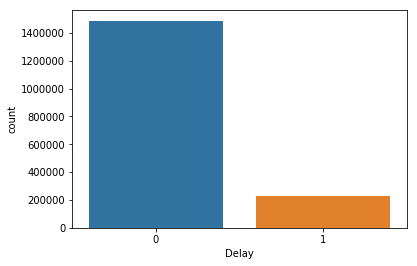

In [15]:
# Bias check
sns.countplot(x="Delay", data=df)

In [0]:
# Check Correlation
def cramers_corrected_stat(x, y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

#### Month

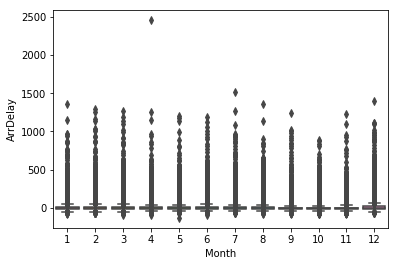

In [17]:
sns.boxplot(x='Month', y='ArrDelay', data=df) #x is feature, y is target

In [18]:
cramers_corrected_stat(df['Delay'], df['Month'])

0.118762

#### DayofMonth

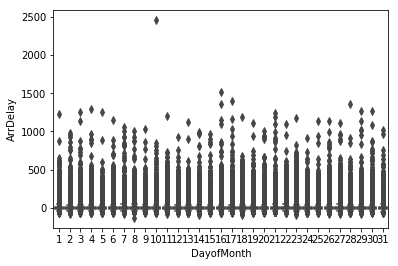

In [19]:
sns.boxplot(x='DayofMonth', y='ArrDelay', data=df) #x is feature, y is target

In [20]:
cramers_corrected_stat(df['Delay'], df['DayofMonth'])

0.035147

#### Weekend

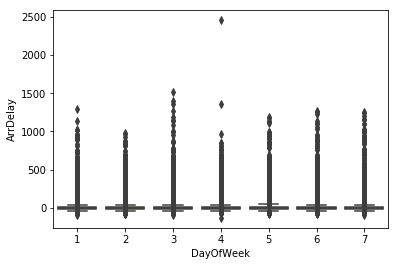

In [21]:
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df) #x is feature, y is target

In [22]:
cramers_corrected_stat(df['Delay'], df['DayOfWeek'])

0.036733

#### Parts of the Day

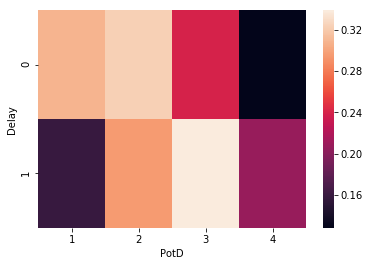

In [23]:
sns.heatmap(pd.crosstab(df['Delay'], df['PotD'], normalize='index'))

In [24]:
cramers_corrected_stat(df['Delay'], df['PotD'])

0.136636

### Encoding

In [0]:
# Apply One-hot encoding to Dest column

df = pd.concat([df, pd.get_dummies(df['Dest'], prefix='Dest',dummy_na=True)],axis=1).drop(['Dest'],axis=1)

In [0]:
# Apply One-hot encoding to UniqueCarrier column

df = pd.concat([df, pd.get_dummies(df['UniqueCarrier'], prefix='UniqueCarrier',dummy_na=True)],axis=1).drop(['UniqueCarrier'],axis=1)

In [27]:
df.head()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay,Dest_ABE,Dest_ABI,Dest_ABQ,Dest_ABY,Dest_ACK,Dest_ACT,Dest_ACV,Dest_ACY,Dest_ADK,Dest_ADQ,Dest_AEX,Dest_AGS,Dest_AKN,Dest_ALB,Dest_ALO,Dest_AMA,Dest_ANC,Dest_ASE,Dest_ATL,Dest_ATW,Dest_AUS,Dest_AVL,Dest_AVP,Dest_AZO,Dest_BDL,Dest_BET,Dest_BFL,Dest_BGM,...,Dest_TPA,Dest_TRI,Dest_TUL,Dest_TUP,Dest_TUS,Dest_TVC,Dest_TWF,Dest_TXK,Dest_TYR,Dest_TYS,Dest_VLD,Dest_VPS,Dest_WRG,Dest_WYS,Dest_XNA,Dest_YAK,Dest_YKM,Dest_YUM,Dest_nan,UniqueCarrier_9E,UniqueCarrier_AA,UniqueCarrier_AQ,UniqueCarrier_AS,UniqueCarrier_B6,UniqueCarrier_CO,UniqueCarrier_DL,UniqueCarrier_EV,UniqueCarrier_F9,UniqueCarrier_FL,UniqueCarrier_HA,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
4112614,7,19,6,225.0,175.0,-10.0,18.0,1389,7.0,15.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1094727,2,20,3,75.0,46.0,-12.0,-2.0,258,8.0,11.0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4756308,8,3,7,145.0,110.0,16.0,21.0,852,9.0,21.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2427833,5,14,3,120.0,106.0,0.0,2.0,737,3.0,9.0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6959741,12,11,4,160.0,164.0,17.0,-8.0,972,6.0,15.0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Model evaluation

In [0]:
# Why?
# Airline:
# Dest Airport + CRSArrTime: 
# Departure features:


X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

#### Features engineering

##### Dimension reduction using PCA

In [0]:
#Standar Scaler

from sklearn.preprocessing import StandardScaler

numeric_features = ['Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'PotD']
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]


# Fit on training set only.
scaler = StandardScaler().fit(X_train_numeric)


    
# Apply transform to both the training set and the test set.
X_train_numeric = scaler.transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

#PCA
from sklearn.decomposition import PCA

# Fit on training set only.
pca = PCA(n_components=1).fit(X_train_numeric)

# Apply transform to both the training set and the test set.
X_train.insert(0, 'PCA', pca.transform(X_train_numeric))
X_test.insert(0, 'PCA', pca.transform(X_test_numeric))
#X_train['PCA'] = pca.transform(X_train_numeric)
#X_test['PCA'] = pca.transform(X_test_numeric)

X_train.drop(numeric_features, axis = 1, inplace = True)
X_test.drop(numeric_features, axis = 1, inplace= True)

In [0]:
X_train.head()

##### Features selection using RFE

In [0]:
# RFE
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 10, step = 5)

#### Naive Bayes

In [0]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [0]:
# Metrics
# https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b
# Confusion Matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

#### Logistic Regression using GridSearchCV

In [0]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = {'C' : [1, 5, 10]}

model_cv = GridSearchCV(estimator = LogisticRegression(), 
                        param_grid = grid, cv = 3, scoring = 'f1', n_jobs = -1)

model_cv.fit(X_data, y_data)

print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

Tune hyper parameters using 3-values-method, with f1 metric.

#### Gradient Boosting
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

In [0]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [0]:
# Metrics
from sklearn.metrics import roc_curve, auc

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

#### Random Forest
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [29]:
# Default parameters
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = -1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


We will use F1 score as the evaluation metric. Our target value is binary so it’s a binary classification problem, and out data is inbalance, so in this case F1 score is a good way for evaluation for this type of problems.

In [30]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
f1

0.876499881432298

In [0]:
# n_estimators
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
for estimator in n_estimators:
  model = RandomForestClassifier(n_estimators = estimator, n_jobs = -1)
  model.fit(X_train, y_train)
  
  train_pred = model.predict(X_train)
  f1 = f1_score(y_train, train_pred)
  train_results.append(f1)
  
  y_pred = model.predict(X_test)
  f1 = f1_score(y_test, y_pred)
  test_results.append(f1)

#### SVC
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769


# TODO

1. Edit threshhold / class weight
2. PCA: Dimension reducing
3. RFE: Features selection
4. GridsearchCV for tuning
- Tuning with 3 values
- Goal: Precison ~ Recall (F1 score)
5. Compare performances among models